<a href="https://colab.research.google.com/github/Abhiram102000/SkinCancerDetection/blob/main/SCDv1_ISIC2019_ENB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Exporting the libraries
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score

import os
import glob
import zipfile
import random

# to get consistent results after multiple runs
tf.random.set_seed(10)
np.random.seed(10)
random.seed(10)

# 0 for benign, 1 for malignant
class_names = ["benign", "malignant"]


In [ ]:
def download_and_extract_dataset():
  # dataset from ISIC 2019 Challenge Data
  train_url = "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip"

  for i, download_link in enumerate([train_url]):
    temp_file = f"temp{i}.zip"
    data_dir = get_file(origin=download_link, fname=os.path.join(os.getcwd(), temp_file))
    print("Extracting", download_link)
    with zipfile.ZipFile(data_dir, "r") as z:
      z.extractall("data")
    # remove the temp file
    os.remove(temp_file)

# comment the below line if you already downloaded the dataset
download_and_extract_dataset()

9771630592/9771618190 [==============================] - 203s 0us/step
Extracting https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip


In [ ]:
import shutil

train_path = "data/train/"
test_path = "data/test/"
valid_path = "data/valid/"

#os.makedirs(train_path + "benign/")
#os.makedirs(train_path + "malignant/")
#os.makedirs(test_path + "benign/")
#os.makedirs(test_path + "malignant/")
#os.makedirs(valid_path + "benign/")
#os.makedirs(valid_path + "malignant/")

test_samples = train_samples = valid_samples =  0

for line in open("data/ISIC_2019_Training_GroundTruth.csv").readlines()[1:]:
  split_line = line.split(",")
  img_name = split_line[0]
  benign_malignant = split_line[1]
  
  r = random.random()

  if r < 0.6:
    loc = train_path
    train_samples += 1
  
  elif r < 0.75:
    loc = valid_path
    valid_samples += 1

  else:
    loc = test_path
    test_samples += 1


  if int(float(benign_malignant)) == 0:
    shutil.move("data/ISIC_2019_Training_Input/" + img_name + ".jpg", loc + "benign/" + img_name + ".jpg")
  elif int(float(benign_malignant)) == 1:
    shutil.move("data/ISIC_2019_Training_Input/" + img_name + ".jpg", loc + "malignant/" + img_name + ".jpg")
  
print(f"Number of training examples {train_samples}")
print(f"Number of test examples {test_samples}")
print(f"Number of valid examples {valid_samples}")


Number of training examples 15351
Number of test examples 6235
Number of valid examples 3745


In [ ]:
def generate_csv(folder, label2int):
    folder_name = os.path.basename(folder)
    labels = list(label2int)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
        print("Reading", os.path.join(folder, label, "*"))
        for filepath in glob.glob(os.path.join(folder, label, "*")):
            df.loc[i] = [filepath, label2int[label]]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)

generate_csv("data/train", {"benign": 0, "malignant": 1})
generate_csv("data/valid", {"benign": 0, "malignant": 1})
generate_csv("data/test", {"benign": 0, "malignant": 1})


Reading data/train/benign/*
Reading data/train/malignant/*
Saving train.csv
Reading data/valid/benign/*
Reading data/valid/malignant/*
Saving valid.csv
Reading data/test/benign/*
Reading data/test/malignant/*
Saving test.csv


In [ ]:
train_metadata_filename = "train.csv"
valid_metadata_filename = "valid.csv"

df_train = pd.read_csv(train_metadata_filename)
df_valid = pd.read_csv(valid_metadata_filename)
n_training_samples = len(df_train)
n_validation_samples = len(df_valid)

print("Number of training samples:", n_training_samples)
print("Number of validation samples:", n_validation_samples)
train_ds = tf.data.Dataset.from_tensor_slices((df_train["filepath"], df_train["label"]))
valid_ds = tf.data.Dataset.from_tensor_slices((df_valid["filepath"], df_valid["label"]))


Number of training samples: 15351
Number of validation samples: 3745


In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [299, 299])


def process_path(filepath, label):
  # load the raw data from the file as a string
  img = tf.io.read_file(filepath)
  img = decode_img(img)
  return img, label

valid_ds = valid_ds.map(process_path)
train_ds = train_ds.map(process_path)
# test_ds = test_ds
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (299, 299, 3)
Label: 0


In [ ]:
batch_size = 128
optimizer = "rmsprop"

def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

valid_ds = prepare_for_training(valid_ds, batch_size=batch_size, cache="valid-cached-data")
train_ds = prepare_for_training(train_ds, batch_size=batch_size, cache="train-cached-data")

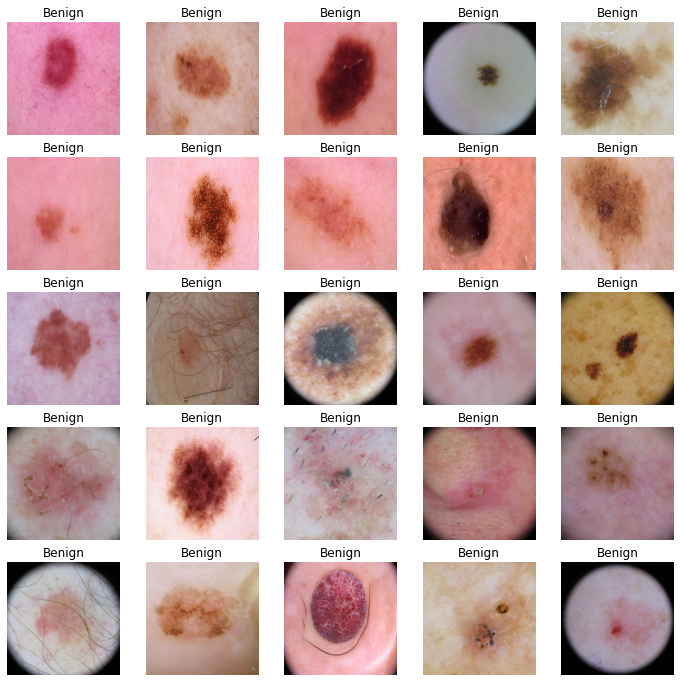

In [ ]:
batch = next(iter(valid_ds))

def show_batch(batch):
  plt.figure(figsize=(12,12))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(batch[0][n])
      plt.title(class_names[batch[1][n].numpy()].title())
      plt.axis('off')
        
show_batch(batch)

In [ ]:
module_url = "https://tfhub.dev/tensorflow/efficientnet/b7/classification/1"
m = tf.keras.Sequential([
    hub.KerasLayer(module_url, output_shape=[2048], trainable=False),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

m.build([None, 299, 299, 3])
m.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              66658680  
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 66,659,681
Trainable params: 1,001
Non-trainable params: 66,658,680
_________________________________________________________________


In [ ]:
model_name = f"benign-vs-malignant_{batch_size}_{optimizer}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", model_name))
# saves model checkpoint whenever we reach better weights
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name + "_{val_loss:.3f}.h5", save_best_only=True, verbose=1)

history = m.fit(train_ds, validation_data=valid_ds, 
                steps_per_epoch=n_training_samples // batch_size, 
                validation_steps=n_validation_samples // batch_size, verbose=1, epochs=1,
                callbacks=[tensorboard, modelcheckpoint])


119/119 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.8179  
Epoch 00001: val_loss improved from inf to 0.64111, saving model to benign-vs-malignant_128_rmsprop_0.641.h5
119/119 [==============================] - 12244s 103s/step - loss: 0.6624 - accuracy: 0.8179 - val_loss: 0.6411 - val_accuracy: 0.8381


In [ ]:
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)
n_testing_samples = len(df_test)
print("Number of testing samples:", n_testing_samples)
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  return ds


test_ds = test_ds.map(process_path)
test_ds = prepare_for_testing(test_ds, cache="test-cached-data")


Number of testing samples: 6235


In [ ]:
y_test = np.zeros((n_testing_samples,))
X_test = np.zeros((n_testing_samples, 299, 299, 3))
for i, (img, label) in enumerate(test_ds.take(n_testing_samples)):
  # print(img.shape, label.shape)
  X_test[i] = img
  y_test[i] = label.numpy()

In [ ]:
print("y_test.shape:", y_test.shape)

In [ ]:
m.load_weights("benign-vs-malignant_128_rmsprop_0.420.h5")

In [ ]:
print("Evaluating the model...")
loss, accuracy = m.evaluate(X_test, y_test, verbose=0)
print("Loss:", loss, "  Accuracy:", accuracy)

In [ ]:
def get_predictions(threshold=None):
  """
  Returns predictions for binary classification given `threshold`
  For instance, if threshold is 0.3, then it'll output 1 (malignant) for that sample if
  the probability of 1 is 30% or more (instead of 50%)
  """
  y_pred = m.predict(X_test)
  if not threshold:
    threshold = 0.5
  result = np.zeros((n_testing_samples,))
  for i in range(n_testing_samples):
    # test melanoma probability
    if y_pred[i][0] >= threshold:
      result[i] = 1
    # else, it's 0 (benign)
  return result

threshold = 0.23

y_pred = get_predictions(threshold)
accuracy_after = accuracy_score(y_test, y_pred)
print("Accuracy after setting the threshold:", accuracy_after)

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  cmn = confusion_matrix(y_test, y_pred)
  # Normalise
  cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
  # print it
  print(cmn)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f', 
              xticklabels=[f"pred_{c}" for c in class_names], 
              yticklabels=[f"true_{c}" for c in class_names],
              cmap="Blues"
              )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  # plot the resulting confusion matrix
  plt.show()


def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """
    # prepare for figure
    plt.figure()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    # obtain ROC AUC
    roc_auc = auc(fpr, tpr)
    # print score
    print(f"ROC AUC: {roc_auc:.3f}")
    # plot ROC curve
    plt.plot(fpr, tpr, color="blue", lw=2,
                label='ROC curve (area = {f:.2f})'.format(d=1, f=roc_auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()

plot_confusion_matrix(y_test, y_pred)
plot_roc_auc(y_test, y_pred)
sensitivity = sensitivity_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred)

print("Melanoma Sensitivity:", sensitivity)
print("Melanoma Specificity:", specificity)

In [ ]:
def plot_images(X_test, y_pred, y_test):
  predicted_class_names = np.array([class_names[int(round(id))] for id in y_pred])

  plt.figure(figsize=(10,9))
  for n in range(30, 60):
      plt.subplot(6,5,n-30+1)
      plt.subplots_adjust(hspace = 0.3)
      plt.imshow(X_test[n])
      # get the predicted label
      predicted_label = predicted_class_names[n]
      # get the actual true label
      true_label = class_names[int(round(y_test[n]))]
      if predicted_label == true_label:
          color = "blue"
          title = predicted_label.title()
      else:
          color = "red"
          title = f"{predicted_label.title()}, true:{true_label.title()}"
      plt.title(title, color=color)
      plt.axis('off')
  _ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
  plt.show()

plot_images(X_test, y_pred, y_test)



In [ ]:
print(history.history.keys())

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()